In [1]:
#EPieters HW5
#Question 1

In [26]:
import numpy as np
import matplotlib.pyplot as mpl
import glob
from simple_read_ligo import read_file, read_template
import json as json

data_dir = 'LOSC_Event_tutorial/'

In [3]:
#WINDOWING: use kaiser window
#add an extended flat region at the top of the kaiser window
#default is an eigth of the window
def flattop_kaiser(m, beta, flat=1/8, DEBUG=False):
    m_win = int(m*(1-flat))
    m_win += int(m_win%2) #want an even number
    
    win = np.kaiser(m_win, beta)
    pad = np.ones(m-m_win)
    win_full= np.insert(win, int(m_win/2), pad)
    
    if DEBUG:
        mpl.figure()
        mpl.plot(win)
        mpl.plot(win_full)
        mpl.show()
    
    return win_full


#plot the FT of the data with different methods:
#without window, with kaiser window, with flat kaiser window
#returns data with flat kaiser window and with kaiser window
def examine_window_methods(data, beta, flat=1/8, DEBUG=False):
    m = len(data)
    win_kaiser = np.kaiser(m, beta)
    win_flatkaiser = flattop_kaiser(m, beta, flat)
    
    data_kaiser = data*win_kaiser
    data_flatkaiser = data*win_flatkaiser
    
    fft_data = np.fft.rfft(data)
    fft_data_kaiser = np.fft.rfft(data_kaiser)
    fft_data_flatkaiser = np.fft.rfft(data_flatkaiser)

    mpl.figure()
    mpl.plot(win_kaiser)
    mpl.plot(win_flatkaiser)
    mpl.title('Windows')
    mpl.legend(['kaiser', 'kaiser with flat top'])
    mpl.show()
    
    mpl.figure()
    mpl.loglog(np.abs(fft_data))
    mpl.loglog(np.abs(fft_data_kaiser))
    mpl.loglog(np.abs(fft_data_flatkaiser))
    mpl.title('FFT of windowed data')
    mpl.legend(['No window', 'kaiser', 'kaiser with flat top'])
    mpl.show()
    
    if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(fft_data_kaiser))
            mpl.title('FFT of kaiser windowed data')
            mpl.show()
            
            mpl.figure()
            mpl.loglog(np.abs(fft_data_flatkaiser))
            mpl.title('FFT of flat kaiser windowed data')
            mpl.show()
    
    return fft_data_flatkaiser, fft_data_kaiser
    


['LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5']
LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5


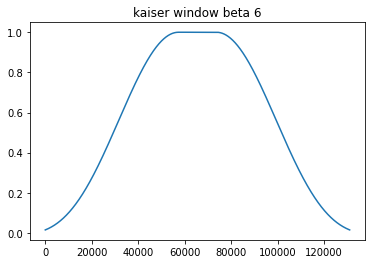

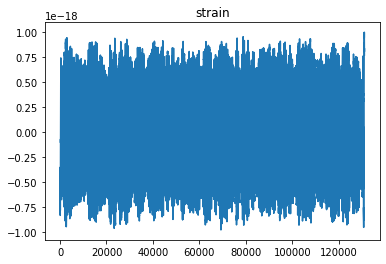

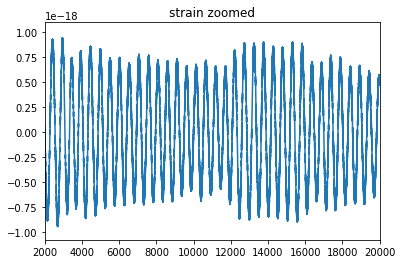

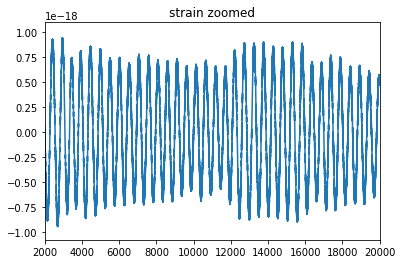

dt is  0.000244140625
utc is  b'2017-01-04T10:11:44'


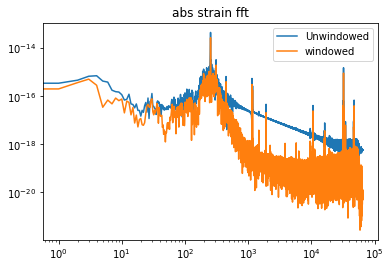

In [4]:
#read in data and have a look!

fnames=glob.glob(data_dir + "[HL]-*.hdf5")
print(fnames)
fname=fnames[0]
print(fname)
# fname='H-H1_LOSC_4_V2-1126259446-32.hdf5'
strain, dt, utc = read_file(fname)


#window
beta = 6
win = flattop_kaiser(len(strain), beta)
mpl.figure()
mpl.plot(win)
mpl.title('kaiser window beta ' + repr(beta))

#strain: fractional difference in length to 10^-19
strainwin = strain*win
strainfft = np.fft.rfft(strain)
strainwinfft = np.fft.rfft(strainwin)

freqs = np.fft.fftfreq(len(strainfft), dt)

mpl.figure()
mpl.plot(strain)
mpl.title('strain')
mpl.show()

mpl.figure()
mpl.plot(strain)
mpl.title('strain zoomed')
mpl.xlim([2000, 20000])
mpl.show()

mpl.figure()
mpl.plot(strain)
mpl.title('strain zoomed')
mpl.xlim([2000, 20000])
mpl.show()


mpl.figure()
mpl.loglog(np.abs(strainfft))
mpl.loglog(np.abs(strainwinfft))
# mpl.loglog(freqs, np.abs(strainfft))
mpl.title('abs strain fft')
mpl.legend(['Unwindowed', 'windowed'])


print('dt is ', dt)
print('utc is ', utc)

['LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5', 'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5']
['LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5', 'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5']


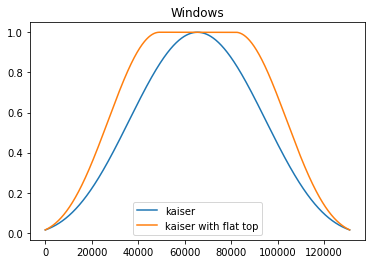

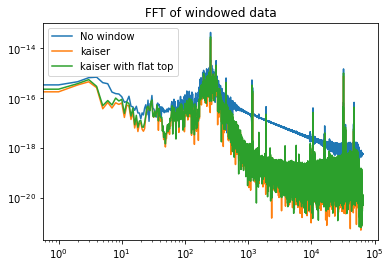

In [5]:
#PART A: come up with a noise model for Livingston and Hanford seperately
livingston_files = glob.glob(data_dir + "L-*.hdf5")
hanford_files = glob.glob(data_dir + "H-*.hdf5")
print(livingston_files)
print(hanford_files)

#NOISE: changes statistically with FREQUENCY. does NOT change statistically with time. STATIONARY NOISE.
#at least on short time scales anyways.....
#STATIONARY NOISE: diagonal in fourier space. look at FT of data

#go from windowed FT to noise model.

#Sievers first try: np.abs(strainfftwin)**2 squared window use as N.
#smooth and deal with peaks.

#try livingston first
strain, dt, utc = read_file(hanford_files[0])
fft_data_flatkaiser, fft_data_kaiser = examine_window_methods(strain, 6, flat=1/4, DEBUG=False)

sum of  box should now be 1  1.0000000000000002
is total power convserved? these should be the same 
(-5.4151227667785715e-21+3.87422539645574e-20j) (-5.415122766778818e-21+3.874225396455729e-20j)


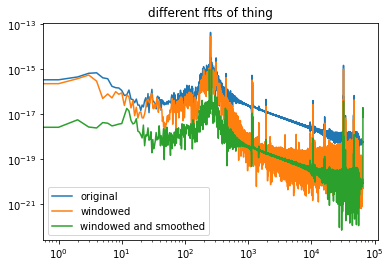

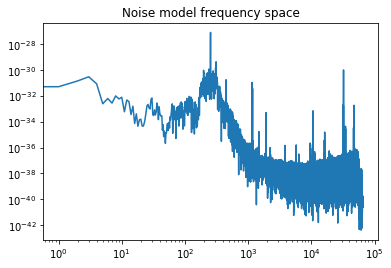

In [33]:
#now come up with smoothing mechanism

#create boxcar smooth taking maximum
def boxcar_smooth(data, m, take_max=True, DEBUG=False):
    box = np.zeros(len(data))
    #make symmetrix boxcar
    box[:m] = 1
    box[-m:] = 1
    box = box/sum(box) #normalize
    print('sum of  box should now be 1 ', sum(box))

#     if DEBUG:
#         mpl.figure()
#         mpl.plot(box)
#         mpl.show()
    
    #convolve the boxcar with the data
    smooth_data = np.fft.ifft( np.fft.fft(data) * np.fft.fft(box) , len(data))
    
    if DEBUG:
        print('is total power convserved? these should be the same ')
        print(np.mean(data), np.mean(smooth_data))
    
    if take_max:
        max_smooth_data = np.maximum(data, smooth_data)
        
        print(np.mean(max_smooth_data))
        
        if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(data))
            mpl.loglog(np.abs(smooth_data))
#             mpl.loglog(np.abs(max_smooth_data))
            mpl.title('max data')
#             mpl.legend(['ogirinal', 'smoothed', 'max'])
            mpl.show()
            
        return max_smooth_data
    
    return smooth_data
    

x = boxcar_smooth(fft_data_flatkaiser, 10, take_max = False, DEBUG=True)

mpl.figure()
mpl.loglog(np.abs(strainfft))
mpl.loglog(np.abs(fft_data_flatkaiser))
mpl.loglog(np.abs(x))
mpl.title('different ffts of thing')
mpl.legend(['original', 'windowed', 'windowed and smoothed'])
mpl.show()


fft_data_flatkaiser_smooth = fft_data_flatkaiser #HACK for now

#finally produce noise matrix
Nft = np.abs(fft_data_flatkaiser_smooth)**2

mpl.figure()
mpl.loglog(Nft)
mpl.title('Noise model frequency space')
mpl.show()

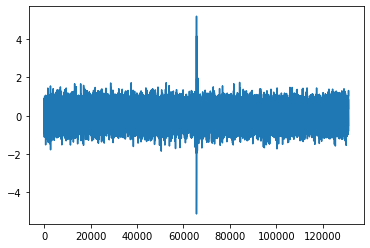

In [41]:
#PART B: use formula

#make function select_template, reads json file tells you which template to use
    #windowed data, window template
#then use formula with correlation to search through for events

def get_template(fname):
#     json_file = 
    with open(data_dir + 'BBH_events_v3.json') as json_file: 
        template_dict = json.load(json_file)
    for ii in template_dict:
        if data_dir + template_dict[ii]['fn_H1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            th, tl = read_template(data_dir + tname + '_4_template.hdf5') #read in template file
            return th 
        if data_dir + template_dict[ii]['fn_L1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            th, tl = read_template(data_dir + tname + '_4_template.hdf5') #read in template file
            return tl
    print('ERROR: template not found for file ', fname)
    return 0

def search_data(template, data, Nft=1):
    return np.fft.irfft( np.conj(np.fft.rfft(template)) * (np.fft.rfft(data)/Nft), len(data))

#get the template and simply run the correlation

template = get_template(hanford_files[0])
win = flattop_kaiser(len(template), beta)

template_win = template*win
strain_win = strain*win


search = search_data(template_win, strain_win, Nft)

mpl.figure()
mpl.plot(search)
mpl.show()
    

In [8]:
#PART C: use other formula

#noise / standard deviation is the usual sqr(inv(AT N-1 A))
#signal to noise ratio is the m/sigma, the cross correlation divided by the error


#TODO: how to get SNR for COMBINED events?? multiply.....??


In [9]:
#PART D:
#compare SNR from scatter in matched filter to analytic SNR from noise model. m/D vs eyeballing on graph?
#so basically matched filter correlation look 

In [10]:
#PART E:
#look at power spectrum in prewhiteened space. N-1/2*A, then FT.